# KNN Modelo


In [20]:
import pandas as pd
import preprocessing as pp
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [21]:
# Devuelve set de datos en un dataframe
def getDataTrain():
  return pd.read_csv("https://docs.google.com/spreadsheets/d/1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0/export?format=csv&gid=2054774482")  

In [22]:
# Devuelve set de datos para predecir en un dataframe
def getDataValidation():
  return pd.read_csv("https://docs.google.com/spreadsheets/d/1ObsojtXfzvwicsFieGINPx500oGbUoaVTERTc69pzxE/export?format=csv&gid=972751642")  

In [23]:
# Devuelve el archivo de salida con las predicciones
def getResult(predictions_final, file_name):
  pd_predictions_final = pd.DataFrame(columns=["id", "tiene_alto_valor_adquisitivo"])
  pd_predictions_final.tiene_alto_valor_adquisitivo = predictions_final
  pd_predictions_final['id'] = pd_predictions_final.index + 1
  pd_predictions_final.set_index('id', inplace=True)
  pd_predictions_final.to_csv(file_name)

In [24]:
# Divido el set en entrenamiento y validacion
dfTrain = getDataTrain()
dfTrain_feature_engineering = pp.feature_engineering_KNN_SVM_Naive_Bayes(dfTrain)
X = dfTrain_feature_engineering.drop(columns = 'tiene_alto_valor_adquisitivo')
y = dfTrain_feature_engineering.tiene_alto_valor_adquisitivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [25]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Metricas

# Accuracy

In [26]:
accuracy_score(y_test, y_pred)

0.8071549209273761

# Precision

In [27]:
precision_score(y_test, y_pred)

0.597864768683274

# Recall

In [28]:
recall_score(y_test, y_pred, pos_label=0)

0.8865917302288238

# F1 Score

In [29]:
f1_score(y_test, y_pred)

0.5722070844686648

# Matriz de confusion

In [30]:
confusion_matrix(y_test, y_pred)

array([[4417,  565],
       [ 691,  840]])

# AUC-ROC

In [31]:
def plot_roc(_fpr, _tpr, x):
    roc_auc = auc(_fpr, _tpr)

    plt.figure(figsize=(15, 10))
    plt.plot(_fpr, _tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.scatter(_fpr, x)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

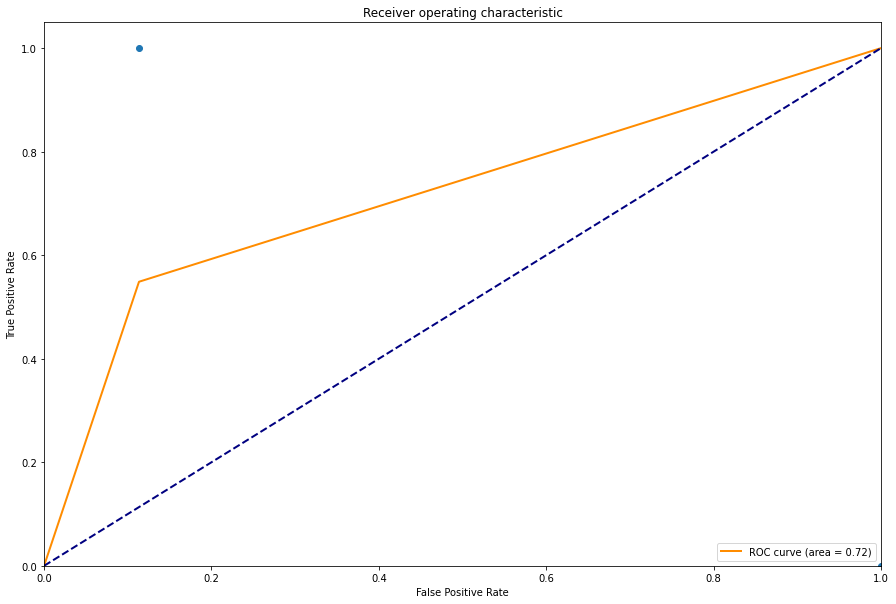

0.7176263680536672

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plot_roc(fpr, tpr, thresholds)
display(roc_auc_score(y_test, y_pred))

# Prediccion

In [33]:
# Obtengo el set para predecir
dfObjetivo = getDataValidation()

# Elimino columnas "representatividad_poblacional" y "id"
dfObjetivo.drop(columns = ['representatividad_poblacional', 'id'], inplace = True)

# Aplico feature engineering
dfObjetivo_feature_engineering = pp.feature_engineering_KNN_SVM_Naive_Bayes(dfObjetivo)

predicciones = knn.predict(dfObjetivo_feature_engineering)
predicciones

array([0, 0, 0, ..., 1, 1, 1])

In [34]:
getResult(predicciones, 'pd_predictions_final_knn.csv')